In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.integrate import odeint

# Define parameters

Biological Parameters

In [2]:
T = 332.15#-30 #Temperature in Kelvin

#mol fraction of incoming gas
y_co = 0.4 #[mol/mol]
y_co2 = 0.2 #[mol/mol]
y_h2 = 0.38 #[mol/mol]
y_o2 = 0.01 #[mol/mol]
y_n2 = 0.01 #[mol/mol]

#Universal constants:
R = 8.314 # [m^3*Pa/K/mol]

In [3]:
a_G = 1000 #kJ/CmolX
print("a_G =", a_G, "[kJ/CmolX]")

a_G = 1000 [kJ/CmolX]


\[REF] Heijnen J.J. (2010) Impact of Thermodynamic Principles in Systems Biology. In: Wittmann C., Krull R. (eds) Biosystems Engineering II. Advances in Biochemical Engineering / Biotechnology, vol 121. Springer, Berlin, Heidelberg. https://doi.org/10.1007/10_2009_63

5.1.1 Gibbs Energy for Maintenance

### Calculate Gibbs free energy and Enthalpy

<p>Given the reaction stoichiometries:</p>
<p>$ -2 CO_2 - 4 H_2 + CH_3COOH + 2 H_2O $</p>
<p>$ -4 CO - 2 H_2O + CH_3COOH + 2 CO_2 $</p>

In [4]:
DfG0_actn = -159.7 
DfH0_actn = -248.4
DfG0_actt = -389.9
DfH0_actt = -505.7
DfG0_co2 = -394.4
DfH0_co2 = -393.5
DfG0_co = -137.2
DfH0_co = -110.5
DfG0_h2o = -237.1
DfH0_h2o = -285.8
DfG0_h2 = 0
DfH0_h2 = 0

#Hess's law:
DrG0_carb = -4*DfG0_co - 2*DfG0_h2o + DfG0_actt + 2*DfG0_co2
DrG0_hom = -4*DfG0_h2 - 2*DfG0_co2 + DfG0_actt + 2*DfG0_h2o 

print("Gibbs energy:\n",
      " DrG0_carb =",round(DrG0_carb,1),"[kJ/mol]\n",
      " DrG0_hom =",round(DrG0_hom,1),"[kJ/mol]\n")

DrH0_carb = -4*DfH0_co - 2*DfH0_h2o + DfH0_actt + 2*DfH0_co2
DrH0_hom = -4*DfH0_h2 - 2*DfH0_co2 + DfH0_actt + 2*DfH0_h2o

print("Enthalpy:\n",
      " DrH0_carb =", round(DrH0_carb,1),"[kJ/mol]\n",
      " DrH0_hom =", round(DrH0_hom,1),"[kJ/mol]\n")

#Gibbs–Helmholtz equation for temperature correction
DrGT_carb = DrG0_carb * (T/298.15) + DrH0_carb * (1-T/298.15)
DrGT_hom = DrG0_hom * (T/298.15) + DrH0_hom * (1-T/298.15)

print("Temperature corrected Gibbs energy:\n",
      " DrGT_carb =",round(DrGT_carb,1),"[kJ/mol]\n",
      " DrGT_hom =",round(DrGT_hom,1),"[kJ/mol]")

#dropped concentration correction, in accordance with book

Gibbs energy:
  DrG0_carb = -155.7 [kJ/mol]
  DrG0_hom = -75.3 [kJ/mol]

Enthalpy:
  DrH0_carb = -279.1 [kJ/mol]
  DrH0_hom = -290.3 [kJ/mol]

Temperature corrected Gibbs energy:
  DrGT_carb = -141.6 [kJ/mol]
  DrGT_hom = -50.8 [kJ/mol]


Reaction-specific substrate requirement for growth:

In [5]:
a_CO = a_G/(DrGT_carb/4) #based on stoichiometry of electron donor
a_H2 = a_G/(DrGT_hom/4) #based on stoichiometry of electron donor

print("Substrate required for growth:\n",
      "a_CO = ",round(a_CO,1), "[molCO/CmolX]\n",
      "a_H2 = ",round(a_H2,1), "[molH2/CmolX]")

Substrate required for growth:
 a_CO =  -28.2 [molCO/CmolX]
 a_H2 =  -78.8 [molH2/CmolX]


## Determine anabolic reaction, biomass formation stoichiometry

<p>With an apporximated biomass composition of $ CH_{1.8}O_{0.5}N_{0.2} $ and ammonia, $ NH_3 $ as carbon source, a prediction of the stoichiometry for the biomass formation reaction can be made by balancing out all elements in each of the reactions:</p>

<p>$ -r_{CO2} CO_2 - r_{H} H_2 - r_{Am} NH_3 + CH_{1.8}O_{0.5}N_{0.2} + r_{W} H_2O = 0$ </p>
<p>$ -r_{CO} CO - r_{W} H_2O - r_{Am} NH_3 + CH_{1.8}O_{0.5}N_{0.2} + r_{CO2} CO_2 = 0$</p>

Which results in:

<p>$ -CO_2 - 2.1 H_2 - 0.2 NH_3 + CH_{1.8}O_{0.5}N_{0.2} + 1.5 H_2O = 0$ </p>
<p>$ -2.1 CO - 0.6 H_2O - 0.2 NH_3 + CH_{1.8}O_{0.5}N_{0.2} + 1.1 CO_2 = 0$</p>

## Combine catabolic and anabolic reactions

Carboxydotrophic

In [6]:
r_carb_CO = -2.1+4*a_CO/4
r_carb_W = -0.6+2*a_CO/4
r_carb_Am = -0.2
r_carb_X = 1
r_carb_actt = -a_CO/4
r_carb_CO2 = 1.1-2*a_CO/4

print(f"Overall Carboxydotrophic stoichiometry at {T}K: \n {round(r_carb_CO,2)} CO {round(r_carb_W,2)} H20 {round(r_carb_Am,2)} NH3 + {round(r_carb_X,2)} biomass + {round(r_carb_actt,2)} CH3COOH + {round(r_carb_CO2,2)} CO2 = 0 \n")

print("Yields on substrate:","\n",
      "r_carb_CO =", round(r_carb_CO,2), "\n",
      "r_carb_W =", round(r_carb_W,2), "\n",
      "r_carb_Am =", round(r_carb_Am,2), "\n",
      "r_carb_X =", round(r_carb_X,2), "\n",
      "r_carb_actt =", round(r_carb_actt,2), "\n",
      "r_carb_CO2 =", round(r_carb_CO2,2), "\n",
      "Y_carb_XS =", round(r_carb_X/r_carb_CO,3), "\n",
      "Y_carb_PS =", round(r_carb_actt/r_carb_CO,3), "\n",
      "Y_carb_PX =", round(r_carb_actt/r_carb_X,3))

Overall Carboxydotrophic stoichiometry at 332.15K: 
 -30.34 CO -14.72 H20 -0.2 NH3 + 1 biomass + 7.06 CH3COOH + 15.22 CO2 = 0 

Yields on substrate: 
 r_carb_CO = -30.34 
 r_carb_W = -14.72 
 r_carb_Am = -0.2 
 r_carb_X = 1 
 r_carb_actt = 7.06 
 r_carb_CO2 = 15.22 
 Y_carb_XS = -0.033 
 Y_carb_PS = -0.233 
 Y_carb_PX = 7.061


Homoacetogenic

In [7]:
r_hom_CO2 = -1 + 2*a_H2/4
r_hom_H2 = -2.1 + 4*a_H2/4
r_hom_Am = -0.2
r_hom_X = 1
r_hom_actt = -a_H2/4
r_hom_W = 1.5 - 2*a_H2/4

print(f"Overall Homoacetogenic stoichiometry at {T}K: \n {round(r_hom_CO2,2)} CO2 {round(r_hom_H2,2)} H2 {round(r_hom_Am,2)} NH3 + {round(r_hom_X,2)} biomass + {round(r_hom_actt,2)} CH3COOH + {round(r_hom_W,2)} H2O = 0 \n")


print("Yields on substrate:","\n",
      "r_hom_CO2 =", round(r_hom_CO2,2), "\n",
      "r_hom_H2 =", round(r_hom_H2,2), "\n",
      "r_hom_Am =", round(r_hom_Am,2), "\n",
      "r_hom_X =", round(r_hom_X,2), "\n",
      "r_hom_actt =", round(r_hom_actt,2), "\n",
      "r_hom_W =", round(r_hom_W,2), "\n",
      "Y_homo_XS =", round(r_hom_X/r_hom_H2,3), "\n",
      "Y_homo_PS =", round(r_hom_actt/r_hom_H2,3), "\n",
      "Y_homo_PX =", round(r_hom_actt/r_hom_X,3))


Overall Homoacetogenic stoichiometry at 332.15K: 
 -40.38 CO2 -80.87 H2 -0.2 NH3 + 1 biomass + 19.69 CH3COOH + 40.88 H2O = 0 

Yields on substrate: 
 r_hom_CO2 = -40.38 
 r_hom_H2 = -80.87 
 r_hom_Am = -0.2 
 r_hom_X = 1 
 r_hom_actt = 19.69 
 r_hom_W = 40.88 
 Y_homo_XS = -0.012 
 Y_homo_PS = -0.244 
 Y_homo_PX = 19.692


## Calculate an estimate for maintenance requierment

REF: L. Tijhuis, M.C. M. van Loosdrecht, and J. J. Heijnen, A Thermodynamically Based Correlation for Maintenance Gibbs Energy Requirements in Aerobic and Anaerobic Chemotrophic Growth 

In [8]:
m_G = 3.3**(69000/R*(1/298-1/T)) #[kJ/h/CmolX]
print("m_G =", round(m_G,2), "[kJ/h/CmolX]")

m_G = 30.53 [kJ/h/CmolX]


Convert to maintenance substrate requirement

In [9]:
m_carb = m_G/(DrGT_carb/4) #[molCO/h/CmolX] based on stoichiometry of electron donor
m_hom = m_G/(DrGT_hom/4) #[molCO/h/CmolX] based on stoichiometry of electron donor

print("Substrate required for maintenance:\n",
      "m_carb = ",round(m_carb,1), "[molCO/h/CmolX]\n",
      "m_hom = ",round(m_hom,1), "[molH2/h/CmolX]")

Substrate required for maintenance:
 m_carb =  -0.9 [molCO/h/CmolX]
 m_hom =  -2.4 [molH2/h/CmolX]


### Michaelis-Menten Parameters

In [10]:
#Ks_h2 = 2.31*(10**(-6))*1000 #mM Michaelis constant for Hydrogen
#Ks_co2 = 4.0*(10**(-5))*1000 #mM Michaelis constant for CO2, not stated in the paper, taken from CO
#Ks_co = 4.0*(10**(-5))*1000 #mM Michaelis constant for CO

Ks_h2 =  0.000033 # from BRENDA, Clostridium acetobutylicum [mM]
Ks_co2 =  1 # from BRENDA, middle of a wide range: 0.0157 - 50 [mM]
Ks_co = 0.01 # from BRENDA, Moorella thermoacetica [mM]

Ki_actt = 813.6 #mM Inhibition constant for acetone

µ_max_hom = 8.140/24 #[/h]
µ_max_carb = 3.910/24 #[/h] 

Get better parameters for gas uptake kinetics from BRENDA


CODH for CO: https://www.brenda-enzymes.org/enzyme.php?ecno=1.2.7.4 

formate dehydrogenase for CO2: https://www.brenda-enzymes.org/enzyme.php?ecno=1.17.1.9

ferredoxin hydrogenase for H2: https://www.brenda-enzymes.org/enzyme.php?ecno=1.12.7.2

Are they temperature dependent?

# Construct Black Box models of Moorella

In [11]:
# Moorella biomass function(s)
def µ_hom(C_h2, C_co2, C_actt):
    #µ_hom = 
    return µ_max_hom * min(C_h2/(Ks_h2+C_h2), C_co2/(Ks_co2+C_co2)) * (1-C_actt/Ki_actt)

def q_hom_CO2(C_h2, C_co2, C_actt):
    #q_hom_CO2 = µ_hom(C_h2, C_co2, C_actt)/(r_hom_X/r_hom_CO2) + (-2/-4) * m_hom
    return µ_hom(C_h2, C_co2, C_actt)/(r_hom_X/r_hom_CO2) + (-2/-4) * m_hom

def q_hom_H2(C_h2, C_co2, C_actt):
    #q_hom_H2 = µ_hom(C_h2, C_co2, C_actt)/(r_hom_X/r_hom_H2) + m_hom
    return µ_hom(C_h2, C_co2, C_actt)/(r_hom_X/r_hom_H2) + m_hom

def q_hom_actt(C_h2, C_co2, C_actt):
    #q_hom_actt = µ_hom(C_h2, C_co2, C_actt)/(r_hom_X/r_hom_actt) + (1/-4) * m_hom
    return µ_hom(C_h2, C_co2, C_actt)/(r_hom_X/r_hom_actt) + (1/-4) * m_hom

In [12]:
def µ_carb(C_co, C_actt):
    #µ_moth_carb = µ_max_carb * C_co/(Ks_co+C_co) * (1-C_actt/Ki_actt)
    return µ_max_carb * C_co/(Ks_co+C_co) * (1-C_actt/Ki_actt)

def q_carb_CO(C_co, C_actt):
    #q_carb_CO = µ_carb(C_co, C_actt)/(r_carb_X/r_carb_CO) + m_carb
    return µ_carb(C_co, C_actt)/(r_carb_X/r_carb_CO) + m_carb

def q_carb_actt(C_co, C_actt):
    #q_carb_actt = µ_carb(C_co, C_actt)/(r_carb_X/r_carb_actt) + (1/-4) * m_carb
    return µ_carb(C_co, C_actt)/(r_carb_X/r_carb_actt) + (1/-4) * m_carb

def q_carb_CO2(C_co, C_actt):
    #q_carb_CO2 = µ_carb(C_co, C_actt)/(r_carb_X/r_carb_CO2) + (2/-4) * m_carb
    return µ_carb(C_co, C_actt)/(r_carb_X/r_carb_CO2) + (2/-4) * m_carb

## Bubble column setup:

Process Parameters

In [13]:
F_G = 1*10**4 #gas inflow rate (from Steph: (8*10**5 * 8.314 * T)/p_m) [m^3/h]
r = 3 # radius of the reactor [m]
h = 30 # height of the reactor [m]

#deduceable constants
A = math.pi * r**2 #reactor cross-sectional area [m^2]
V_L = A * h * 2/3 #reactor volume, assuming it is 2/3 filled [m^3]
v_gas = F_G/A/3600 #average gas velocity [m/s]
Gas_holdup = 0.6*(v_gas)**0.7 #from Stephanie's paper
V_G = V_L*Gas_holdup

p_t = 101325 # pressure at the top of the reactor [Pa]
p_b = p_t + h * 1000 * 9.81 # pressure at the bottom of the reactor [Pa]
p_m = (p_b-p_t)/math.log(p_b/p_t) # logarithmic mean pressure [Pa]

Define gas transfer rates as functions

In [14]:
# Constants:
# Diffusivity coefficient:
# E.L. Cussler, Diffusion - Mass Transfer in Fluid Systems, 2nd edition - Table 5.2-1
D0_CO = 2.03*10**(-5) #[cm2/s]
D0_CO2 = 1.92*10**(-5) #[cm2/s]
D0_H2 = 4.50*10**(-5) #[cm2/s]
D0_O2 = 2.10*10**(-5) #[cm2/s]
D0_N2 = 1.88*10**(-5) #[cm2/s]

# NIST Chemistry WebBook: https://webbook.nist.gov
theta = 1.022 # temperature correction factor
#Henry's law constant for solubility in water at 298.15 K
H0_CO = 0.00099 # mol/kg*bar]
H0_CO2 = 0.035 # [mol/kg*bar]
H0_H2 = 0.00078 # [mol/kg*bar]
H0_O2 = 0.0013 # [mol/kg*bar]
H0_N2 = 0.0006 # [mol/kg*bar]
#temepratute correction factor k 
k_CO = 1300 # [K]
k_CO2 = 2400 # [K]
k_H2 = 500 # [K]
k_O2 = 1500 # [K]
k_N2 = 1300 # [K]

#Temperature-corrected Henry’s law constant, HT:
HT_CO2 = H0_CO2 * math.e**(k_CO2*(1/T-1/298.15)) * 10**3 * 10**(-5) #[mol/m^3*Pa]
HT_CO = H0_CO * math.e**(k_CO*(1/T-1/298.15)) * 10**3 * 10**(-5) #[mol/m^3*Pa]
HT_H2 = H0_H2 * math.e**(k_H2*(1/T-1/298.15)) * 10**3 * 10**(-5) #[mol/m^3*Pa]
HT_O2 = H0_O2 * math.e**(k_O2*(1/T-1/298.15)) * 10**3 * 10**(-5) #[mol/m^3*Pa]
HT_N2 = H0_N2 * math.e**(k_N2*(1/T-1/298.15)) * 10**3 * 10**(-5) #[mol/m^3*Pa]

#Calculate kLa for each gas, all are poorly water-soluble so kLa >> kGa:
#DT_CO2 = T/298.15 * 1/(((298.15+240)/(T+240))*(T/298.15)**(3/2)) * D0_CO2 #[cm2/s]
#DT_O2 = T/298.15 * 1/(((298.15+127)/(T+127))*(T/298.15)**(3/2)) * D0_O2 #[cm2/s]
KLa_CO2 = 0.32 * (D0_CO2/D0_O2)**0.5 * v_gas**0.7 * theta**(T-293.15) * 3600 #[1/s]

#DT_CO = T/298.15 * 1/(((298.15+118)/(T+118))*(T/298.15)**(3/2)) * D0_CO #[cm2/s]
#DT_O2 = T/298.15 * 1/(((298.15+127)/(T+127))*(T/298.15)**(3/2)) * D0_O2 #[cm2/s]
KLa_CO = 0.32 * (D0_CO/D0_O2)**0.5 * v_gas**0.7 * theta**(T-293.15) * 3600 #[1/s]

#DT_H2 = T/298.15 * 1/(((298.15+72)/(T+72))*(T/298.15)**(3/2)) * D0_H2 #[cm2/s]
#DT_O2 = T/298.15 * 1/(((298.15+127)/(T+127))*(T/298.15)**(3/2)) * D0_O2 #[cm2/s]
KLa_H2 = 0.32 * (D0_H2/D0_O2)**0.5 * v_gas**0.7 * theta**(T-293.15) * 3600 #[1/s]

#DT_N2 = T/298.15 * 1/(((298.15+72)/(T+72))*(T/298.15)**(3/2)) * D0_N2 #[cm2/s]
#DT_O2 = T/298.15 * 1/(((298.15+127)/(T+127))*(T/298.15)**(3/2)) * D0_O2 #[cm2/s]
KLa_N2 = 0.32 * (D0_N2/D0_O2)**0.5 * v_gas**0.7 * theta**(T-293.15) * 3600 #[1/s]

#Define functions to calculate gas mass transfer rates for each gas
def R_CO2(c_co2,cG_co2,cG_Gas):
    return KLa_CO2*(HT_CO2 * cG_co2/(cG_Gas) * p_m * cG_Gas/cG_Gas_0 - c_co2)

def R_CO(c_co,cG_co,cG_Gas):
    return KLa_CO*(HT_CO * cG_co/(cG_Gas) * p_m * cG_Gas/cG_Gas_0 - c_co)

def R_H2(c_h2,cG_h2,cG_Gas):
    return KLa_H2*(HT_H2 * cG_h2/(cG_Gas) * p_m * cG_Gas/cG_Gas_0 - c_h2)

def R_N2(c_n2,cG_n2,cG_Gas):
    return KLa_N2*(HT_N2 * cG_n2/(cG_Gas) * p_m * cG_Gas/cG_Gas_0 - c_n2)

In [15]:
def model(z,t):
    X_carb = max(0,z[0])
    X_hom = max(0,z[1])
    c_actt = max(0,z[2])
    c_co2 = max(0,z[3])
    c_co = max(0,z[4])
    c_h2 = max(0,z[5])
    c_n2 = max(0,z[6])
    cG_co2 = max(0,z[7])
    cG_co = max(0,z[8])
    cG_h2 = max(0,z[9])
    cG_n2 = max(0,z[10])
    
    cG_Gas = cG_co2+cG_co+cG_h2+cG_n2

    dXcdt = µ_carb(c_co, c_actt) * X_carb
    dXhdt = µ_hom(c_h2, c_co2, c_actt) * X_hom
    dacttdt = q_hom_actt(c_h2, c_co2, c_actt) * X_hom + q_carb_actt(c_co, c_actt) * X_carb
    dCO2dt = q_hom_CO2(c_h2, c_co2, c_actt) * X_hom + q_carb_CO2(c_co, c_actt) * X_carb + R_CO2(c_co2,cG_co2,cG_Gas)
    dCOdt = q_carb_CO(c_co, c_actt) * X_carb + R_CO(c_co,cG_co,cG_Gas)
    dH2dt = q_hom_H2(c_h2, c_co2, c_actt) * X_hom + R_H2(c_h2,cG_h2,cG_Gas)
    dN2dt = R_N2(c_n2,cG_n2,cG_Gas)
    dCO2Gdt = F_G/V_G * (cG_co2_in-cG_co2) - R_CO2(c_co2,cG_co2,cG_Gas) * V_L/V_G
    dCOGdt = F_G/V_G * (cG_co_in-cG_co) - R_CO(c_co,cG_co,cG_Gas) * V_L/V_G
    dH2Gdt = F_G/V_G * (cG_h2_in-cG_h2) - R_H2(c_h2,cG_h2,cG_Gas) * V_L/V_G
    dN2Gdt = F_G/V_G * (cG_n2_in-cG_n2) - R_N2(c_n2,cG_n2,cG_Gas) * V_L/V_G
    
    return [dXcdt,dXhdt,dacttdt,dCO2dt,dCOdt,dH2dt,dN2dt,dCO2Gdt,dCOGdt,dH2Gdt,dN2Gdt]

For the initial gas concentrations: 
 - in the liquid, one can assume that they have reached saturation before starting the experiment
 - in the gas, one can take the inlet concentrations

In [16]:
#initial conditions
cG_co2_in = y_co2 * p_m/(R*T)
cG_co_in = y_co * p_m/(R*T)
cG_h2_in = y_h2 * p_m/(R*T)
cG_n2_in = y_n2 * p_m/(R*T)

c_co2_0 = HT_CO2 * y_co2 * p_m
c_co_0 =  HT_CO * y_co * p_m
c_h2_0 =  HT_H2 * y_h2 * p_m
c_n2_0 =  HT_H2 * y_n2 * p_m

cG_Gas_0 = cG_co2_in+cG_co_in+cG_h2_in+cG_n2_in

#z0=[c_n2_0,cG_n2_in]
z0=[0.1,0.01,0,c_co2_0,c_co_0,c_h2_0,c_n2_0,cG_co2_in,cG_co_in,cG_h2_in,cG_n2_in]

#step function
t_rt = 100
t = np.linspace(0,t_rt,1000)

#solve ODE
z = odeint(model,z0,t)

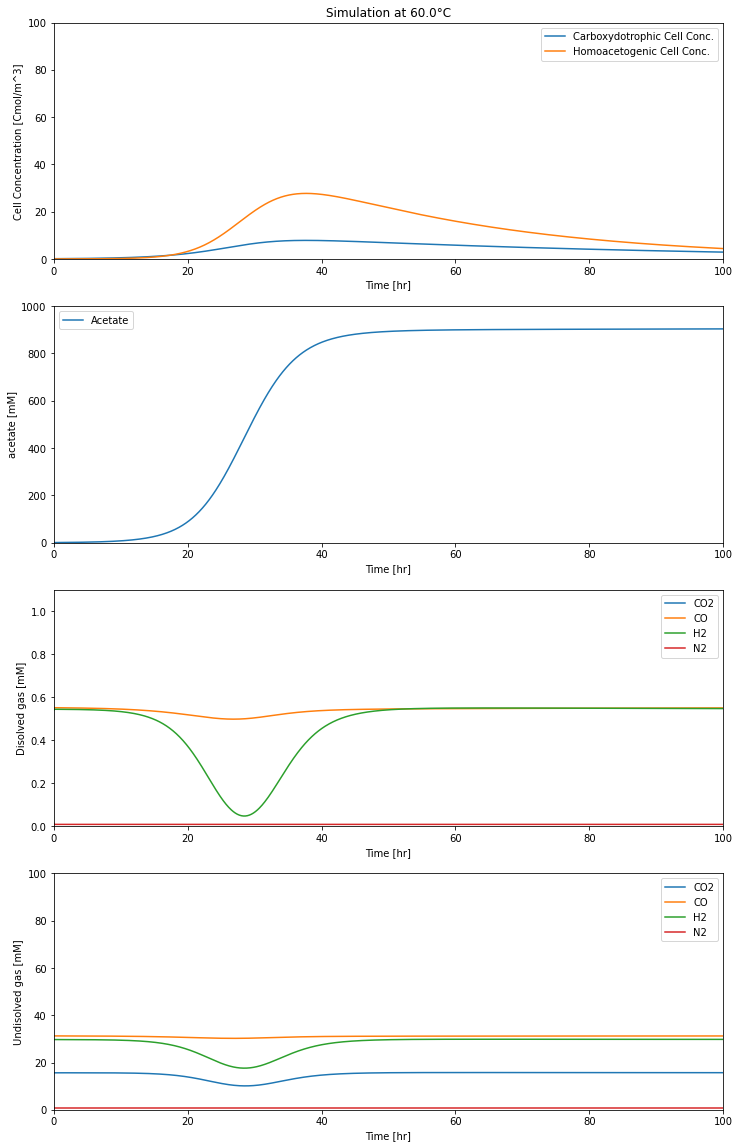

In [17]:
fig = plt.figure(figsize=(12,20))

#Output results
plt.subplot(4,1,1)
plt.title(f"Simulation at {T-272.15}°C")
plt.plot(t,z[:,0])
plt.plot(t,z[:,1])
plt.xlabel('Time [hr]')
plt.ylabel('Cell Concentration [Cmol/m^3]')
plt.axis([0, t_rt, 0, 100])
plt.legend(['Carboxydotrophic Cell Conc.','Homoacetogenic Cell Conc.'])

plt.subplot(4,1,2)
plt.plot(t,z[:,2])
plt.xlabel('Time [hr]')
plt.ylabel('acetate [mM]')
plt.axis([0, t_rt, 0, 1000])
plt.legend(['Acetate'])

plt.subplot(4,1,3)
plt.plot(t,z[:,3])
plt.plot(t,z[:,4])
plt.plot(t,z[:,5])
plt.plot(t,z[:,6])
plt.xlabel('Time [hr]')
plt.ylabel('Disolved gas [mM]')
plt.axis([0, t_rt, 0, 1.1])
plt.legend(['CO2','CO',"H2","N2"])

plt.subplot(4,1,4)
plt.plot(t,z[:,7])
plt.plot(t,z[:,8])
plt.plot(t,z[:,9])
plt.plot(t,z[:,10])
plt.xlabel('Time [hr]')
plt.ylabel('Undisolved gas [mM]')
plt.axis([0, t_rt, 0, 100])
plt.legend(['CO2','CO',"H2","N2"])